In [13]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp

import tomllib
import sys, os

from iminuit import Minuit
from iminuit.cost import LeastSquares
from math import sqrt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [14]:
#create line function
def func(x,*pars):
    return pars[1]*x+pars[0]



In [15]:
# Linearized, correlated error propagation, given the params and errors --> better version of error_func
def prop_err(t,fun,args,errargs,corrs):
    ep=10**4
    errj=np.array([])
    t=np.asarray(t).reshape(1, -1)[0,:]
    for j in range(len(t)):
        err=np.array([])
        for i in range(len(args)):
            up=args.copy()
            up[i]=args[i]+errargs[i]/ep
            do=args.copy()
            do[i]=args[i]-errargs[i]/ep
            err=np.append(err,(eval(fun)(t[j],*up)-eval(fun)(t[j],*do))*ep/2)
        errj=np.append(errj,np.sqrt(np.dot(err,np.dot(corrs,err))))
    return errj

<ErrorbarContainer object of 3 artists>

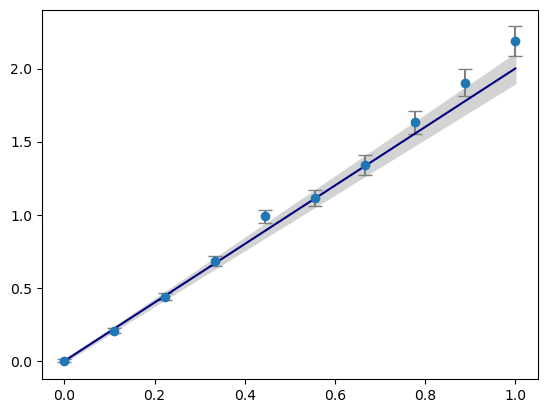

In [16]:
#generating fake data using actual error function
#array for x data
x_data = np.linspace(0, 1, 10)

pars = [0,2]
err_pars = [0.01,0.1]
corr = np.diag(np.ones(len(pars)), 0) #correlation matrix, with diagonal entries --> 2x2

# Compute error for each x data point
errors = prop_err(x_data, 'func', pars, err_pars,corr)

#y data array
y_perf = func(x_data, *pars) #selected truth

y_data = np.random.normal(y_perf, errors) #perfect data + gaussian noise

# Plotting
plt.errorbar(x_data, y_data, errors, fmt='o', ecolor='gray', capsize=5)
plt.plot(x_data, y_perf, color = 'navy',label='Line Function')

plt.fill_between(x_data, y_perf + errors, y_perf - errors, color = 'lightgrey')


plt.show()

In [17]:
least_squares = LeastSquares(x_data, y_data, errors, func)

m = Minuit(least_squares, 0,2)  # 0,2 are the param values, in minuit its the initial values for the line which is 0, but we used a defined arr

m.migrad().hesse()  # finds minimum of least_squares function
#m.hesse()   # accurately computes uncertainties (matrix)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.158 (χ²/ndof = 0.9)      │              Nfcn = 41               │
│ EDM = 2.38e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  -0.007   │   0.009   │            │            │         │         │       │
│ 1 │ x1   │   2.09    │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │ 7.47e-05 -0.18e-3 │
│ x1 │ -0.18e-3  0.00168 │
└────┴───────────────────┘

In [19]:
#actual values versus least squares fit pars
fit_pars = np.array(m.values)
fit_errors = np.array(m.errors)

err = prop_err(x_data, func, fit_pars, fit_errors)

#y data array
fity_perf = func(x_data, *fit_pars)

# Plotting
plt.errorbar(x_data, y_data, errors, fmt='o', ecolor='gray', capsize=5)
plt.plot(x_data, y_perf, color = 'navy',label='Line Function')
plt.plot(x_data, fity_perf, color = 'orange',label='Line Function')
#plt.errorbar(x_data, func(x_data, params) + errors, label='Line Function + Error')
#plt.errorbar(func(x_data, params) - errors, label='Line Function - Error')

plt.fill_between(x_data, y_perf + errors, y_perf - errors, color = 'lightgrey')
plt.fill_between(x_data, fity_perf + err, fity_perf - err, color = 'pink', alpha = 0.5)


plt.show()


TypeError: prop_err() missing 1 required positional argument: 'corrs'

In [20]:
# Definning the kcot functions here (eq 3 in paper)
m_pi = 0.13957
m_k = 0.496 #kaon mass
#defining scattering momentum function: q(s) = 1/2sqrt(s - 4(ma)**2), where m_a = mass of particle (in this case pion)
def q(s):
    return (1/2)*np.sqrt(s - 4*m_pi**2)

#defining actual truth --> a line model for the Effective Range Expansion
def ERE(s,*pars):
    s       = np.asarray(s).reshape(1, -1)[0,:]    
    total   = np.zeros(len(s))
    total  += 1/pars[0]
    for j in range(len(s)):    
        for i in range(1,len(pars)):
            total[j]+=pars[i] * (q(s[j])**(2*i)/m_pi**(2*i))
    return total


<ErrorbarContainer object of 3 artists>

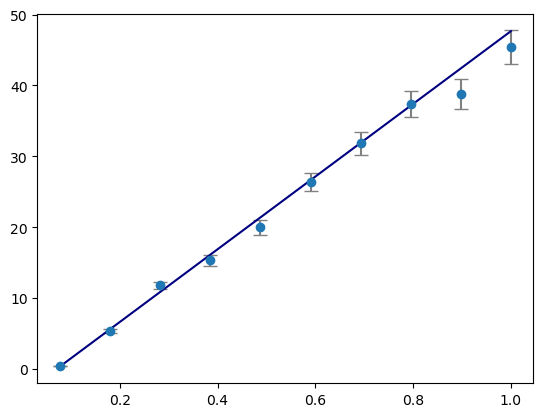

In [21]:
#length 2 pars for kcot error
#array for x data

x2_data = np.linspace(4*m_pi**2,1,10)


#parameter array of length 2
pars2 = [3,4]
err_pars2 = [0.02,0.2]
corr2 = np.diag(np.ones(len(pars2)),0)

# Compute error for each x data point
err2 = prop_err(x2_data, 'ERE', pars2, err_pars2,corr2)

#y data array
y2_perf = ERE(x2_data, *pars2) #truth - using the model (ERE function) we obtain y values as a function of x

y2_data = np.random.normal(y2_perf, err2) #y2_perf is the center (mean), and err2 is the st. dev, so this outputs a random number about the center given its range due to the standard deviation

# Plotting
plt.errorbar(x2_data, y2_data, err2, fmt='o', ecolor='gray', capsize=5)
plt.plot(x2_data, y2_perf, color = 'navy',label='Line Function')


#plt.fill_between(x2_data, y2_perf + err2, y2_perf - err2, color = 'lightgrey')


plt.show()

<ErrorbarContainer object of 3 artists>

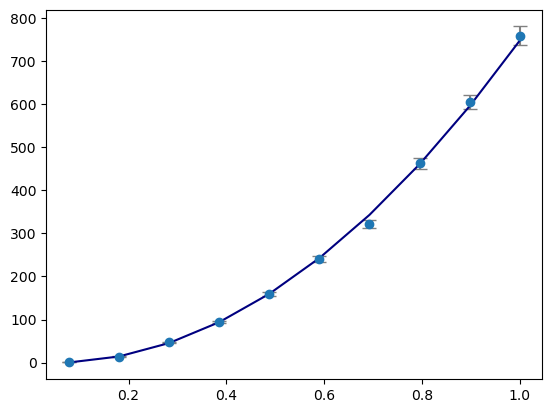

In [22]:
#length 3 pars for kcot error
#array for x data

x3_data = np.linspace(4*m_pi**2,1,10)


#parameter array of length 2
pars3 = [3,4,5]
err_pars3 = [0.02,0.2,0.15]
corr3 = np.diag(np.ones(len(pars3)),0)

# Compute error for each x data point
err3 = prop_err(x3_data, 'ERE', pars3, err_pars3,corr3)

#y data array
y3_perf = ERE(x3_data, *pars3) #truth - using the model (ERE function) we obtain y values as a function of x

y3_data = np.random.normal(y3_perf, err3) #y2_perf is the center (mean), and err2 is the st. dev, so this outputs a random number about the center given its range due to the standard deviation

# Plotting
plt.errorbar(x3_data, y3_data, err3, fmt='o', ecolor='gray', capsize=5)
plt.plot(x3_data, y3_perf, color = 'navy',label='Line Function')


plt.show()

<ErrorbarContainer object of 3 artists>

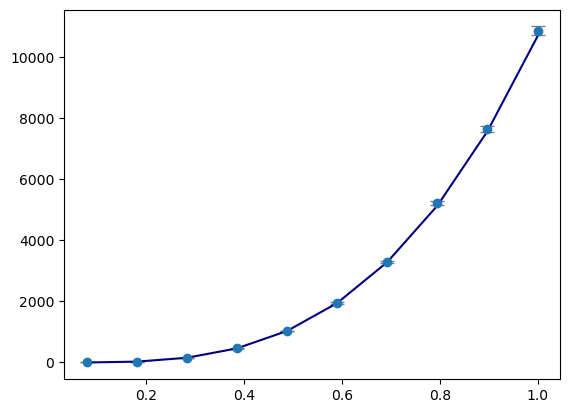

In [23]:
#length 3 pars for kcot error
#array for x data

x4_data = np.linspace(4*m_pi**2,1,10)


#parameter array of length 2
pars4 = [3,4,5,6]
err_pars4 = [0.02,0.2,0.15,0.08]
corr4 = np.diag(np.ones(len(pars4)),0)

# Compute error for each x data point
err4 = prop_err(x4_data, 'ERE', pars4, err_pars4,corr4)

#y data array
y4_perf = ERE(x4_data, *pars4) #truth - using the model (ERE function) we obtain y values as a function of x

y4_data = np.random.normal(y4_perf, err4) #y2_perf is the center (mean), and err2 is the st. dev, so this outputs a random number about the center given its range due to the standard deviation

# Plotting
plt.errorbar(x4_data, y4_data, err4, fmt='o', ecolor='gray', capsize=5)
plt.plot(x4_data, y4_perf, color = 'navy',label='Line Function')


plt.show()

In [24]:
least_squares2 = LeastSquares(x2_data, y2_data, err2, ERE)
least_squares3 = LeastSquares(x3_data, y3_data, err3, ERE)
least_squares4 = LeastSquares(x4_data, y4_data, err4, ERE)

m2 = Minuit(least_squares2, 3,4)
m3 = Minuit(least_squares3, 3,4,5)
m4 = Minuit(least_squares4, 3,4,5,6)

m2.migrad().hesse()
m3.migrad().hesse()
m4.migrad().hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.687 (χ²/ndof = 1.1)      │              Nfcn = 39               │
│ EDM = 3.58e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   3.033   │   0.020   │            │            │         │         │       │
│ 1 │ x1   │   3.90    │   0.07    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │ 0.000418        0 │
│ x1 │        0  0.00444 │
└────┴───────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.056 (χ²/ndof = 1.2)      │              Nfcn = 69               │
│ EDM = 4.1e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   3.015   │   0.020   │            │            │         │         │       │
│ 1 │ x1   │   4.14    │   0.32    │            │            │         │         │       │
│ 2 │ x2   │   4.98    │   0.08    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       x0       x1       x2 │
├────┼────────────────────────────┤
│ x0 │ 0.000408        0       -0 │
│ x1 │        0    0.101   -0.021 │
│ x2 │       -0   -0.021  0.00702 │
└────┴────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.781 (χ²/ndof = 0.3)      │              Nfcn = 112              │
│ EDM = 6.69e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   3.013   │   0.020   │            │            │         │         │       │
│ 1 │ x1   │     5     │     1     │            │            │         │         │       │
│ 2 │ x2   │    4.1    │    0.7    │            │            │         │         │       │
│ 3 │ x3   │   6.15    │   0.09    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────┐
│    │       x0       x1       x2       x3 │
├────┼─────────────────────────────────────┤
│ x0 │ 0.000407   0.1e-3       -0        0 │
│ x1 │   0.1e-3     0.95     -0.7    0.075 │
│ x2 │       -0     -0.7    0.535   -0.063 │
│ x3 │        0    0.075   -0.063  0.00843 │
└────┴─────────────────────────────────────┘

In [25]:
#information criteria and other models 
def confm(s,*pars):
    so  = 1.5
    s     = np.asarray(s).reshape(1, -1)[0,:]    
    total = np.zeros(len(s))
    for j in range(len(s)):    
        omega = (np.sqrt(s[j])-np.sqrt(so-s[j]))/(np.sqrt(s[j])+np.sqrt(so-s[j]))
        for i in range(len(pars)):
            total[j]+=pars[i] * omega**i
        total[j]*=np.sqrt(s[j])/2.
    return total

def AIC(total_chi2,ndata,npars):
    return total_chi2+2*npars-2*ndata

def BIC(total_chi2,ndata,npars):
    return total_chi2+np.log(ndata)*npars

def AIC2(total_chi2,ndata,npars):
    return total_chi2+2.*npars*(ndata/(ndata-npars-1.))

In [26]:
#fake data samples; for each we have 10 data points and we model each with errkcot 100 times (sample size)

samples = 100 #fake data samples
datap = 10 #number of data points for each sample
ratio = 0.05 #percent error is fixed
testpars = [3.5,-0.03]
m1 = ERE

errtestp = list(ratio*np.array(testpars))
corr = np.diag(np.ones(len(testpars)), 0)#correlation between parameters

s = np.linspace(4*m_pi**2,4*m_k**2,datap) #xaxis, mandelstam
errperf = prop_err(s, 'm1', testpars, errtestp, corr) #errors for x_data, so vertical error bars

perf = m1(s, *testpars) #perfect data --> truth



y_data = [] #there are 100 arrays in here; each array has ten indices
for i in range(samples):
    y_data.append(np.random.normal(perf,errperf)) #np.random.normal is an array, this is then appended to y as the following array


In [27]:
def find_min_index(lst):
    lst=np.array(lst)
    return np.argwhere(lst == np.min(lst))[0] #min_index

2 -8.045642203360504 12.559527982627593 13.668643510925214 0.9942947245799376
3 409.1665491796539 430.07430445863605 433.1665491796539 60.45236416852196
4 93.99103682148589 115.20137719346211 121.99103682148586 17.665172803580987
5 6045621.760421794 6045643.27334726 6045656.760421796 1209126.3520843592
6 2601106863.766295 2601106885.581805 2601106911.7662945 650276717.9415737


(array([  0., 100.,   0.,   0.,   0.]),
 array([1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 5 artists>)

(array([  0., 100.,   0.,   0.,   0.]),
 array([1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 5 artists>)

(array([  0., 100.,   0.,   0.,   0.]),
 array([1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 5 artists>)

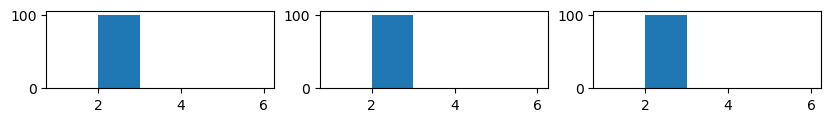

In [29]:
#whats the best number of parameters?
pmin = 2
pmax = 6
model = ERE

fit_AIC = np.zeros(min(pmax, datap)-pmin+1)
fit_BIC = np.zeros(min(pmax, datap)-pmin+1)
fit_AIC2 = np.zeros(min(pmax, datap)-pmin+1)

bestfit_AIC = np.zeros(samples)
bestfit_BIC = np.zeros(samples)
bestfit_AIC2 = np.zeros(samples)


fit_chisqdof = np.zeros(min(pmax, datap)-pmin+1)

for i in range(samples):
    least_squares = LeastSquares(s, y_data[i], errperf, model)
    fit_AIC_in = np.zeros(min(pmax, datap)-pmin+1)
    fit_BIC_in = np.zeros(min(pmax, datap)-pmin+1)
    fit_AIC2_in = np.zeros(min(pmax, datap)-pmin+1)
    for j in range(min(pmax, datap)-pmin+1): #number of times a given model is the best

        init_pars = np.zeros(j+pmin)+1
        m = Minuit(least_squares, *init_pars)
        fit = m.migrad(samples)
        fit_AIC_in[j] = AIC(fit.fval, datap, len(init_pars))
        fit_AIC[j] += AIC(fit.fval, datap, len(init_pars))/samples
        fit_BIC_in[j] = BIC(fit.fval, datap, len(init_pars))
        fit_BIC[j] += BIC(fit.fval, datap, len(init_pars))/samples
        fit_AIC2_in[j] = AIC2(fit.fval, datap, len(init_pars))
        fit_AIC2[j] += AIC2(fit.fval, datap, len(init_pars))/samples
        fit_chisqdof[j] +=fit.fval/fit.ndof/samples
        
    bestfit_AIC[i] =  find_min_index(fit_AIC_in)[0]+pmin
    bestfit_BIC[i] = find_min_index(fit_BIC_in)[0]+pmin
    bestfit_AIC2[i] = find_min_index(fit_AIC2_in)[0]+pmin

for k in range(len(fit_AIC)):
    print(k+pmin, fit_AIC[k], fit_BIC[k], fit_AIC2[k], fit_chisqdof[k])

bins = np.linspace(1,6,6)

fig, axes = plt.subplots(1,3,figsize=(10,1))

axes[0].hist(bestfit_AIC, bins = bins)
axes[1].hist(bestfit_BIC, bins = bins)
axes[2].hist(bestfit_AIC2, bins = bins)

1 93.99103682148589 115.20137719346211 121.99103682148586 17.665172803580987
2 -5.585025535765949 15.625314836210235 22.414974464234046 1.069162410705675


(array([  0., 100.,   0.,   0.,   0.]),
 array([1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 5 artists>)

(array([  0., 100.,   0.,   0.,   0.]),
 array([1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 5 artists>)

(array([  0., 100.,   0.,   0.,   0.]),
 array([1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 5 artists>)

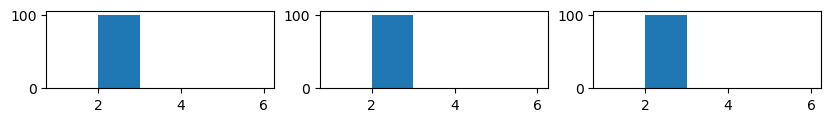

In [30]:
#for fixed number of pars what's the best model?
numpars = 4
models = ['ERE','confm']
mlen = len(models)

fit_AIC = np.zeros(mlen)
fit_BIC = np.zeros(mlen)
fit_AIC2 = np.zeros(mlen)
fit_chisqdof = np.zeros(mlen)

bestfit_AIC = np.zeros(samples)
bestfit_BIC = np.zeros(samples)
bestfit_AIC2 = np.zeros(samples)

for i in range(samples):
    fit_AIC_in = np.zeros(mlen)
    fit_BIC_in = np.zeros(mlen)
    fit_AIC2_in = np.zeros(mlen)
    for j in range(mlen):
        fitm = eval(models[j])
        least_squares = LeastSquares(s, y_data[i], errperf, fitm)
        init_pars = np.zeros(numpars)+1
        m = Minuit(least_squares, *init_pars)
        fit = m.migrad(samples)
        
        fit_AIC_in[j] = AIC(fit.fval, datap, len(init_pars))
        fit_AIC[j] += AIC(fit.fval, datap, len(init_pars))/samples
        
        fit_BIC_in[j] = BIC(fit.fval, datap, len(init_pars))
        fit_BIC[j] += BIC(fit.fval, datap, len(init_pars))/samples
        
        fit_AIC2_in[j] = AIC2(fit.fval, datap, len(init_pars))
        fit_AIC2[j] += AIC2(fit.fval, datap, len(init_pars))/samples
        
        fit_chisqdof[j] += fit.fval/fit.ndof/samples
    
    bestfit_AIC[i] = find_min_index(fit_AIC_in)[0]+1
    bestfit_BIC[i] = find_min_index(fit_BIC_in)[0]+1
    bestfit_AIC2[i] = find_min_index(fit_AIC2_in)[0]+1


for k in range(len(fit_AIC)):
    print(k+1, fit_AIC[k], fit_BIC[k], fit_AIC2[k], fit_chisqdof[k])

bins = np.linspace(1,6,6)

fig, axes = plt.subplots(1,3,figsize=(10,1))

axes[0].hist(bestfit_AIC, bins = bins)
axes[1].hist(bestfit_BIC, bins = bins)
axes[2].hist(bestfit_AIC2, bins = bins)

ERE 2 -8.045642203360504 12.559527982627593 13.668643510925214 0.9942947245799376
ERE 3 -7.080733036124875 13.827022242857261 16.91926696387512 0.9884667091250172
ERE 4 -6.027491448342424 15.18284892363376 21.972508551657576 0.9954180919429293
ERE 5 -5.303174132090367 16.20975133287987 29.696825867909634 0.9393651735819272
confm 2 54.01538663041187 74.62055681639993 75.7296723446976 8.751923328801482
confm 3 -2.715698293846108 18.192056985136027 21.28430170615389 1.6120431008791278
confm 4 -5.585025535765949 15.625314836210235 22.414974464234046 1.069162410705675
confm 5 -5.267944789981248 16.244980674988977 29.732055210018757 0.9464110420037495


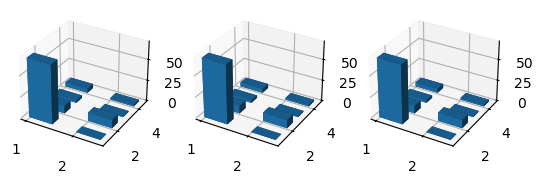

In [31]:
#3D histogram, best number of pars and best model

minp = 2
maxp = 5

mlen = len(models)

fit_AIC = np.zeros((mlen,min(maxp, datap)-minp+1))
fit_BIC = np.zeros((mlen,min(maxp, datap)-minp+1))
fit_AIC2 = np.zeros((mlen,min(maxp, datap)-minp+1))

bestfit_AIC = np.zeros((mlen,min(maxp, datap)-minp+1))
bestfit_BIC  = np.zeros((mlen,min(maxp, datap)-minp+1))
bestfit_AIC2 = np.zeros((mlen,min(maxp, datap)-minp+1))


fit_chisqdof = np.zeros((mlen,min(maxp, datap)-minp+1))

for i in range(samples):

    fit_AIC_in = np.zeros((mlen,min(maxp, datap)-minp+1))
    fit_BIC_in = np.zeros((mlen,min(maxp, datap)-minp+1))
    fit_AIC2_in = np.zeros((mlen,min(maxp, datap)-minp+1))
    
    for j in range(mlen):

        fitm = eval(models[j])
        lsq = LeastSquares(s, y_data[i], errperf, fitm)
        
        for k in range(min(maxp, datap) - minp+1):
            init_pars = np.zeros(k+minp)+1
            m = Minuit(lsq, *init_pars)
            newv = 1000
            fit = m.migrad(newv)
            
            fit_AIC_in[j,k] = AIC(fit.fval, datap, len(init_pars)) 
            fit_AIC[j,k] += AIC(fit.fval, datap, len(init_pars))/samples
            
            fit_BIC_in[j,k] = BIC(fit.fval, datap, len(init_pars))
            fit_BIC[j,k]+=BIC(fit.fval, datap, len(init_pars))/samples
            
            fit_AIC2_in[j,k] = AIC2(fit.fval, datap, len(init_pars))
            fit_AIC2[j,k]+=AIC2(fit.fval, datap, len(init_pars))/samples
            
            fit_chisqdof[j,k] += fit.fval/fit.ndof/samples

    best_index = find_min_index(fit_AIC_in)
    bestfit_AIC[best_index[0],best_index[1]] +=1
    bestfit_BIC[best_index[0],best_index[1]] += 1
    bestfit_AIC2[best_index[0],best_index[1]] += 1

for l in range(mlen):
    for m in range(min(maxp, datap)-minp+1):
        print(models[l],m+minp, fit_AIC[l,m],fit_BIC[l,m],fit_AIC2[l,m],fit_chisqdof[l,m])

fig = plt.figure()

ax1 = fig.add_subplot(1,3,1,projection='3d')
ax2 = fig.add_subplot(1,3,2,projection='3d')
ax3 = fig.add_subplot(1,3,3,projection='3d')
#x, y = np.random.rand(2, 100) * 4
#hist, xedges, yedges = np.histogram2d(x, y, bins=4, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
x = [range(1,bestfit_AIC.shape[0]+1)]
y = [range(1,bestfit_AIC.shape[1]+1)]
xpos, ypos = np.meshgrid(x,y)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros(len(xpos))

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz1 = bestfit_AIC.flatten()
dz2 = bestfit_BIC.flatten()
dz3 = bestfit_AIC2.flatten()

ax1.bar3d(xpos, ypos, zpos, dx, dy, dz1, zsort='average')
ax2.bar3d(xpos, ypos, zpos, dx, dy, dz2, zsort='average')
ax3.bar3d(xpos, ypos, zpos, dx, dy, dz3, zsort='average')

plt.show()


In [32]:
##Classes in Python - Introduction

#Classes in Python are a blueprints for creating objects with specific attributes and methods (functions)

#Attributes are the variables associated with an object (data), and Methods are the functions associated with an object

#Basic Structure:
class classname:
    class_attribute = 'Attribute' #not necessary
    def _init_(self, value): #initializer, value is the instance attribute
        self.value = value
    def method(self): #method
        print("This is the Method")

classname.method(2)

This is the Method


In [33]:
##Finding Resonances in the Second Riemann Sheet

In [34]:
#Complex models
def ERE_complex(xp,*pars):  
    x=xp[0]
    y=xp[1]
    total = 1/pars[0]
    for i in range(1,len(pars)):
        total+=pars[i] * (k2(x,y)**(2*i)/m_pi**(2*i))
    return total

def confm_complex(xp,*pars): 
    x=xp[0]
    y=xp[1]
    total = 0+0j
    omega= (np.sqrt((x+y*1j)**2)-np.sqrt(4*m_k**2-(x+y*1j)**2))/(np.sqrt((x+y*1j)**2)+np.sqrt(4*m_k**2-(x+y*1j)**2))
    for i in range(0,len(pars)):
        total+=pars[i] * omega**i
    total*=np.sqrt((x+y*1j)**2)/2.
    return total

models_complex = ['ERE_complex', 'confm_complex']
pole_bounds=((-1,3),(0,5))

def k2(x,y):
    if (y>=0.):
        fin=np.sqrt((x+y*1j)**2-4*m_pi**2)/2
    else:
        fin=-np.sqrt((x+y*1j)**2-4*m_pi**2)/2
    return fin

In [35]:
#phase shift in degrees
def p_shift(fun,s,*pars):
    return np.arctan(q(s)/func(s,*pars))*180./np.pi

In [36]:
#Defining pole position with linearized and correlated error propagation for an S-wave amplitude
def pole_position_E(fun,pars,errpars,corrs,x0):
    ep=10**3
    nsearches=10
    def abs_den(xp,*pars):
        x=xp[0]
        y=xp[1]
        return abs(fun(xp,*pars)+k2(x,y)*1j)
    spoles,s0 =poles_search(fun,pars,x0,nsearches).poles()

    if (len(spoles)>=1):
        spol=min(spoles, key=lambda xi:abs(xi-s0))
        xpol=np.array([np.real(np.sqrt(spol,dtype=complex)),np.imag(np.sqrt(spol,dtype=complex))])

        errx=np.array([])
        erry=np.array([])

        for i in range(len(pars)):
            up=pars.copy()
            up[i]=pars[i]+errpars[i]/ep
            do=pars.copy()
            do[i]=pars[i]-errpars[i]/ep
            xup = sp.optimize.minimize(abs_den,(xpol[0],xpol[1]),args=(*up,),method='L-BFGS-B',bounds=pole_bounds).x
            xdo = sp.optimize.minimize(abs_den,(xpol[0],xpol[1]),args=(*do,),method='L-BFGS-B',bounds=pole_bounds).x
            errx=np.append(errx,(xup[0]-xdo[0])*ep/2)
            erry=np.append(erry,(xup[1]-xdo[1])*ep/2)

        errxt=np.sqrt(np.dot(errx,np.dot(corrs,errx)))
        erryt=np.sqrt(np.dot(erry,np.dot(corrs,erry)))
        return np.array([xpol[0], abs(xpol[1]), errxt, erryt])
    else:
        return np.array([0,0,0,0])


In [37]:
#Define a class to extract pole position, based on a starting value and number of searches
class poles_search:
    def __init__(self,fun,pars,x0,nsearches):
        self.fun=fun
        self.x0=x0
        self.nsearches=nsearches
        self.pars=pars

    def poles(self):
        fun=self.fun
        x0=self.x0
        s0=(x0[0]+x0[1]*1j)**2
        pars=self.pars

        def den(xp,*pars):
            x=xp[0]
            y=xp[1]
            return abs(fun(xp,*pars)+k2(x,y)*1j)
        
        min=[]
        spol=[]

        for i in range(self.nsearches):
            def denloop(xp,*pars):
                x=xp[0]
                y=xp[1]
                s=(x+y*1j)**2
                sub=1
                for j in range(len(spol)):
                    sub*=(s-spol[j])
                return abs(den(xp,*pars)/sub)
            
            sol=sp.optimize.minimize(denloop,x0,args=(*pars,),method='L-BFGS-B',bounds=pole_bounds,tol=1e-10)
            if (sol.fun<1e-4):
                min.append(sol)
                xpol=min[i].x
                spol.append((xpol[0]+xpol[1]*1j)**2)
        return spol, s0


In [38]:
#Define a class which produces Model Averages (MA) for pole positions, given a list of MA weights and poles list

class pole_avg:
    def __init__(self, weights,poles):
        self.weights=weights
        self.poles=poles

    def avg(self):
        w_list=self.weights
        pole_list=self.poles
        norm=np.sum(w_list)
        xavg=0;yavg=0;xerravg=0;yerravg=0
        for j in range(len(w_list)):
            for i in range(len(w_list[0])):

                xavg    += pole_list[j][i][0]*w_list[j][i]/norm
                yavg    += pole_list[j][i][1]*w_list[j][i]/norm
                xerravg += (pole_list[j][i][0]**2+pole_list[j][i][2]**2)*w_list[j][i]/norm
                yerravg += (pole_list[j][i][1]**2+pole_list[j][i][3]**2)*w_list[j][i]/norm

        xerravg-=xavg**2 ; xerravg**=1/2 ; yerravg-=yavg**2 ; yerravg**=1/2

        return np.array([xavg, yavg, xerravg, yerravg])


        

In [39]:
#Define a class so that given a list of MA criterion values, we get MA weights

class MA_weights:
    def __init__(self, list):
        self.list = list
    
    def weights(self):
        MA_min = np.amin(self.list)
        listmod = self.list - MA_min
        return np.exp(-listmod / 2.)



<function matplotlib.pyplot.figure(num: 'int | str | Figure | SubFigure | None' = None, figsize: 'tuple[float, float] | None' = None, dpi: 'float | None' = None, *, facecolor: 'ColorType | None' = None, edgecolor: 'ColorType | None' = None, frameon: 'bool' = True, FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>, clear: 'bool' = False, **kwargs) -> 'Figure'>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

/var/folders/km/4z94z0p92fl3dwmrcsdc9y4m0000gn/T/ipykernel_46293/1861969563.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  return abs(den(xp,*pars)/sub)
/var/folders/km/4z94z0p92fl3dwmrcsdc9y4m0000gn/T/ipykernel_46293/1861969563.py:31: RuntimeWarning: invalid value encountered in scalar divide
  return abs(den(xp,*pars)/sub)


<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

[0.59677636 0.61594218 0.0334526  0.03237873]


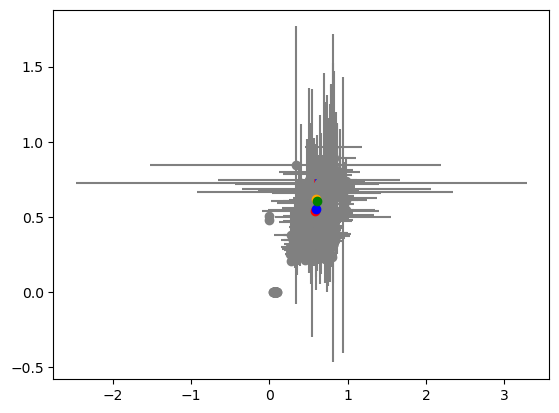

In [40]:
#We have 100 data samples, find the poles for one
orig_vals=[1,0.5]
model = 'ERE'
ini_vals=[pole_position_E(eval('{}_complex'.format(model)),testpars,errtestp,corr,orig_vals)[0],pole_position_E(eval('{}_complex'.format(model)),testpars,errtestp,corr,orig_vals)[1]]


MA_criterions = [AIC, BIC, AIC2]

plt.figure

fit_AIC = []
fit_BIC = []
fit_AIC2 = []

fit_pars = []
fit_poles = []


for i in range(mlen):
    for k in range(samples):
        fit_model = eval(models[i])
        lsq = LeastSquares(s, y_data[k], errperf, fit_model)
        fit_AIC_int = []
        fit_BIC_int = []
        fit_AIC2_int = []
        fit_pars_int = []
        fit_poles_int = []
        for j in range(min(maxp,datap) - minp+1):
            ini_pars = np.zeros(j+minp)+1
            m = Minuit(lsq,*ini_pars)
            m.strategy = 1;ncall = 1000;m.tol = 0.001
            fit = m.migrad(ncall)
            minuit_pars = np.array(fit.values)
            minuit_err = np.array(fit.errors)
            minuit_corr = np.array(fit.covariance.correlation())
            fit_pars_int.append(minuit_pars)
            fit_poles_E = pole_position_E(eval(models_complex[i]), minuit_pars,minuit_err,minuit_corr,ini_vals)
            fit_poles_int.append(fit_poles_E)
        
            if (np.sum(fit_poles_E)>0):
                plt.errorbar(fit_poles_E[0], fit_poles_E[1], yerr = fit_poles_E[2], xerr = fit_poles_E[3], fmt = 'o', color = 'gray') 
                fit_AIC_int.append(AIC(fit.fval,datap, len(ini_pars)))
                fit_BIC_int.append(BIC(fit.fval,datap, len(ini_pars)))
                fit_AIC2_int.append(AIC2(fit.fval,datap,len(ini_pars)))
            else:
                fit_AIC_int.append(1e100)
                fit_BIC_int.append(1e100)
                fit_AIC2_int.append(1e100)
           
        fit_AIC.append(fit_AIC_int)
        fit_BIC.append(fit_BIC_int)
        fit_AIC2.append(fit_AIC2_int)
    
        fit_pars.append(fit_pars_int)
        fit_poles.append(fit_poles_int)

original_pole = pole_position_E(eval('{}_complex'.format(model)),testpars,errtestp,corr,ini_vals)
plt.errorbar(original_pole[0], original_pole[1], yerr = original_pole[2], xerr = original_pole[3], fmt = 'o', color = 'orange')

fit_AIC_weights = MA_weights(fit_AIC).weights()
fit_BIC_weights = MA_weights(fit_BIC).weights()
fit_AIC2_weights = MA_weights(fit_AIC2).weights()

pole_AIC = pole_avg(fit_AIC_weights,fit_poles).avg()
pole_BIC = pole_avg(fit_BIC_weights,fit_poles).avg()
pole_AIC2 = pole_avg(fit_AIC2_weights,fit_poles).avg()

plt.errorbar(pole_AIC[0], pole_AIC[1], yerr = pole_AIC[3], xerr = pole_AIC[2], fmt = 'o',color = 'red')
plt.errorbar(pole_BIC[0], pole_BIC[1], yerr = pole_BIC[3], xerr = pole_BIC[2], fmt = 'o',color = 'blue')
plt.errorbar(pole_AIC2[0], pole_AIC2[1], yerr = pole_AIC2[3], xerr = pole_AIC2[2], fmt = 'o',color = 'green')

#print(fit_AIC)
#print(fit_poles)
#print(pole_AIC2[3])
print(original_pole)


plt.show()